In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import pandas as pd

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

## Low frequency range

Loading data, and cutting bandwidth in half.

In [3]:
data = pd.read_pickle('../../Data/data.pkl')
multinest_results = pd.read_pickle('../../Data/multinest_results.pkl')
# cutting in the low frequency range:
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise[:, :, :143]
HI_noise_data = data.beam.HI_noise[:, :, :143]
freqs = data.freqs[:143]
multinest = multinest_results.wpol_lofreq

PCA foreground removal:

In [4]:
pca_res6 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=6)[0]
pca_res7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

In [5]:
kern_smooth = GPy.kern.RBF(1, variance = multinest.rbf1_var, lengthscale = multinest.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.rbf2_var, lengthscale = multinest.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.exp_var, lengthscale = multinest.exp_len)

Input = FGwpol_HI_noise_data

gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [6]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,57505.27335619189,+ve,
sum.rbf.lengthscale,489.6148983876146,+ve,
sum.rbf_1.variance,5.368353260260953,+ve,
sum.rbf_1.lengthscale,74.52394664469603,+ve,
sum.Exponential.variance,0.001434041875029721,+ve,
sum.Exponential.lengthscale,8.01553747735935,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


Calculate power spectrum:

In [7]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78*(143/285) #Mpc/h
nx, ny, nz = 256, 256, 143
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

In [8]:
# bias correction:
n_samples = 10
pk3d_corr, pk1d_corr, samples = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, 
                                                kbins_par, kbins, w, W)

# spherically averaged power spectrum:

# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
# residual power spectrum from GPR, with bias correction:
GPR_pk = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk3d_corr
# residual power spectrum from PCA:
PCA7_pk = pk.getpk(pca_res7,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
PCA6_pk = pk.getpk(pca_res6,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# radial power spectrum:

# true HI power spectrum:
HI_pk_para = pk.ParaPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
# residual power spectrum from GPR, with bias correction:
GPR_pk_para = pk.ParaPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0] + pk1d_corr
# residual power spectrum from PCA:
PCA7_pk_para = pk.ParaPk(pca_res7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_para = pk.ParaPk(pca_res6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# transverse power spectrum:

# true HI power spectrum:
HI_pk_perp = pk.PerpPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
# residual power spectrum from GPR, with bias correction:
GPR_pk_perp = pk.PerpPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
# residual power spectrum from PCA:
PCA7_pk_perp = pk.PerpPk(pca_res7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA6_pk_perp = pk.PerpPk(pca_res6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

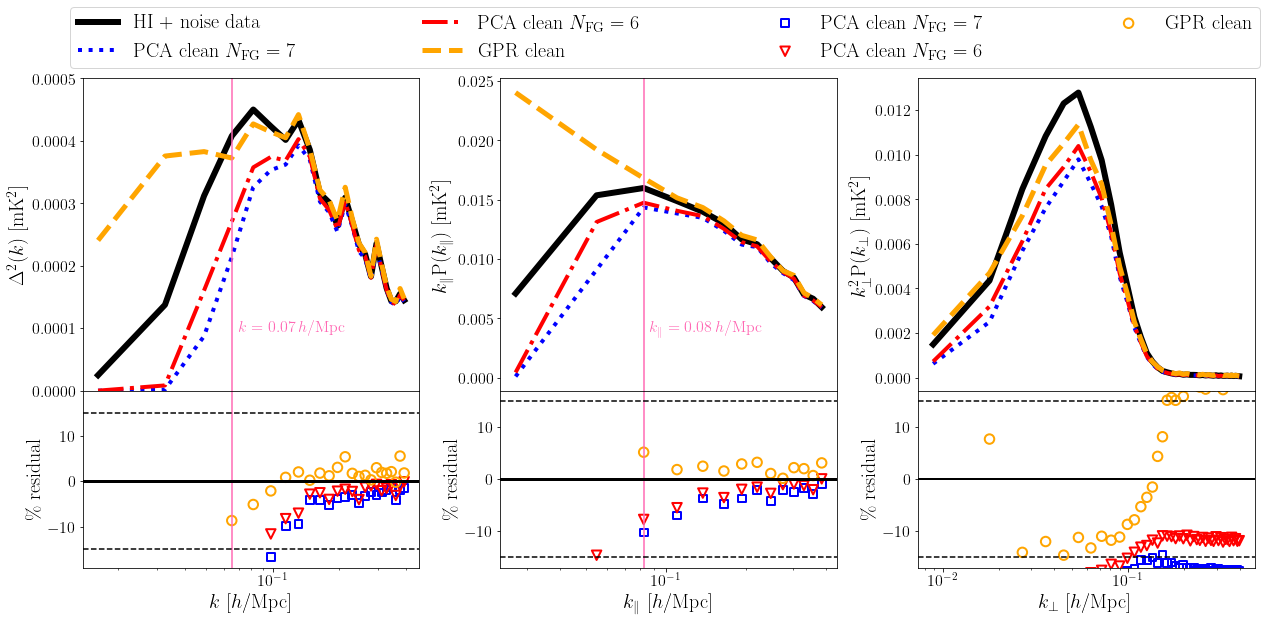

In [9]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=(21,9), gridspec_kw={'height_ratios': [3, 1.7]})
fig.subplots_adjust(hspace=0, wspace=0.24)

ax1.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + noise data')
ax1.plot(k, (k*k*k*PCA7_pk)/(2*np.pi*np.pi), ls='dotted',c='b', lw=4)
ax1.plot(k, (k*k*k*PCA6_pk)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=4)
ax1.plot(k, (k*k*k*GPR_pk)/(2*np.pi*np.pi), ls='dashed', c='orange', lw=5)
ax1.text(k[0]*4.3, 0.000095, r'$k = 0.07 \, h$/Mpc', c='hotpink')
ax1.axvline(k[3], c='hotpink')
ax1.set_xscale('log')
ax1.set_ylim(0,0.0005)
ax1.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax2.scatter(k, 100*(PCA7_pk - HI_pk)/HI_pk, marker='s', s=60, edgecolor='b', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 7$')
ax2.scatter(k, 100*(PCA6_pk - HI_pk)/HI_pk, marker='v', s=90, edgecolor='r', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 6$')
ax2.scatter(k, 100*(GPR_pk - HI_pk)/HI_pk, s=90, marker='o', edgecolor='orange', facecolor='none', lw=2, label = r'GPR clean')
ax2.set_ylim(-19.,19.9)
ax2.axvline(k[3], c='hotpink')
ax2.set_xscale('log')
ax2.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax2.set_ylabel('\% residual', fontsize=20)
ax2.axhline(0, c='k', lw=3)
ax2.axhline(15, c='k', ls='dashed', lw=1.5)
ax2.axhline(-15, c='k', ls='dashed', lw=1.5)

ax3.plot(kpar, kpar*HI_pk_para, ls='solid', c='k', lw=6)
ax3.plot(kpar, kpar*PCA7_pk_para, ls='dotted',c='b', lw=4, label = r'PCA clean $N_{\rm FG} = 7$')
ax3.plot(kpar, kpar*PCA6_pk_para, ls='dashdot',c='r', lw=4)
ax3.plot(kpar, kpar*GPR_pk_para, ls='dashed', c='orange', lw=5)
ax3.text(k[0]*5.3, 0.0039, r'$k_\parallel = 0.08 \, h$/Mpc', c='hotpink')
ax3.axvline(kpar[2], c='hotpink')
ax3.set_xscale('log')
ax3.set_ylabel('$k_\parallel$P($k_\parallel$) [mK$^2$]', fontsize=20)

ax4.scatter(kpar, 100*(PCA7_pk_para - HI_pk_para)/HI_pk_para, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(PCA6_pk_para - HI_pk_para)/HI_pk_para, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(GPR_pk_para - HI_pk_para)/HI_pk_para, s=90, marker='o', edgecolor='orange', facecolor='none', lw=2)
ax4.axvline(kpar[2], c='hotpink')
ax4.set_ylim(-17,17)
ax4.set_xscale('log')
ax4.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax4.set_ylabel('\% residual', fontsize=20)
ax4.axhline(0, c='k', lw=3)
ax4.axhline(15, c='k', ls='dashed', lw=1.5)
ax4.axhline(-15, c='k', ls='dashed', lw=1.5)

ax5.plot(kperp, kperp*kperp*HI_pk_perp, ls='solid', c='k', lw=6)
ax5.plot(kperp, kperp*kperp*PCA7_pk_perp, ls='dotted',c='b', lw=4)
ax5.plot(kperp, kperp*kperp*PCA6_pk_perp, ls='dashdot',c='r', lw=4, label = r'PCA clean $N_{\rm FG} = 6$')
ax5.plot(kperp, kperp*kperp*GPR_pk_perp, ls='dashed', c='orange', lw=5, label = r'GPR clean')
ax5.set_xscale('log')
ax5.set_ylabel('$k_\perp^2$P($k_\perp$) [mK$^2$]', fontsize=20)

ax6.scatter(kperp, 100*(PCA7_pk_perp - HI_pk_perp)/HI_pk_perp, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax6.scatter(kperp, 100*(PCA6_pk_perp - HI_pk_perp)/HI_pk_perp, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax6.scatter(kperp, 100*(GPR_pk_perp - HI_pk_perp)/HI_pk_perp, s=90, marker='o', edgecolor='orange', facecolor='none', lw=2)
ax6.set_ylim(-17,17)
ax6.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax6.set_ylabel('\% residual', fontsize=20)
ax6.axhline(0, c='k', lw=2)
ax6.axhline(15, c='k', ls='dashed', lw=1.5)
ax6.axhline(-15, c='k', ls='dashed', lw=1.5)

fig.legend(bbox_to_anchor=(0.11, 0.88, 0.8, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)

#plt.savefig('../figs/pk_all_wpol_lofreq', dpi=300, bbox_inches="tight")

## High frequency range

Here we do the exact same thing but now for the high frequency range

In [10]:
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise[:, :, 143:]
HI_noise_data = data.beam.HI_noise[:, :, 143:]
freqs = data.freqs[143:]
multinest = multinest_results.wpol_hifreq

In [11]:
pca_res6 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=6)[0]
pca_res7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

In [12]:
kern_smooth = GPy.kern.RBF(1, variance = multinest.rbf1_var, lengthscale = multinest.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.rbf2_var, lengthscale = multinest.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.exp_var, lengthscale = multinest.exp_len)

Input = FGwpol_HI_noise_data

gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [13]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,27100.161877710034,+ve,
sum.rbf.lengthscale,588.6059567105364,+ve,
sum.rbf_1.variance,4.057359254480211,+ve,
sum.rbf_1.lengthscale,106.97714921463871,+ve,
sum.Exponential.variance,0.0011284317859334247,+ve,
sum.Exponential.lengthscale,6.220363145411224,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


In [14]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78*(142/285) #Mpc/h
nx, ny, nz = 256, 256, 142
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

In [15]:
# bias correction:
n_samples = 10
pk3d_corr, pk1d_corr, samples = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, 
                                                kbins_par, kbins, w, W)

# spherically averaged power spectrum:

# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
# residual power spectrum from GPR, with bias correction:
GPR_pk = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk3d_corr
# residual power spectrum from PCA:
PCA7_pk = pk.getpk(pca_res7,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
PCA6_pk = pk.getpk(pca_res6,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

# radial power spectrum:

# true HI power spectrum:
HI_pk_para = pk.ParaPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
# residual power spectrum from GPR, with bias correction:
GPR_pk_para = pk.ParaPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0] + pk1d_corr
# residual power spectrum from PCA:
PCA7_pk_para = pk.ParaPk(pca_res7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_para = pk.ParaPk(pca_res6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# transverse power spectrum:

# true HI power spectrum:
HI_pk_perp = pk.PerpPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
# residual power spectrum from GPR, with bias correction:
GPR_pk_perp = pk.PerpPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
# residual power spectrum from PCA:
PCA7_pk_perp = pk.PerpPk(pca_res7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA6_pk_perp = pk.PerpPk(pca_res6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

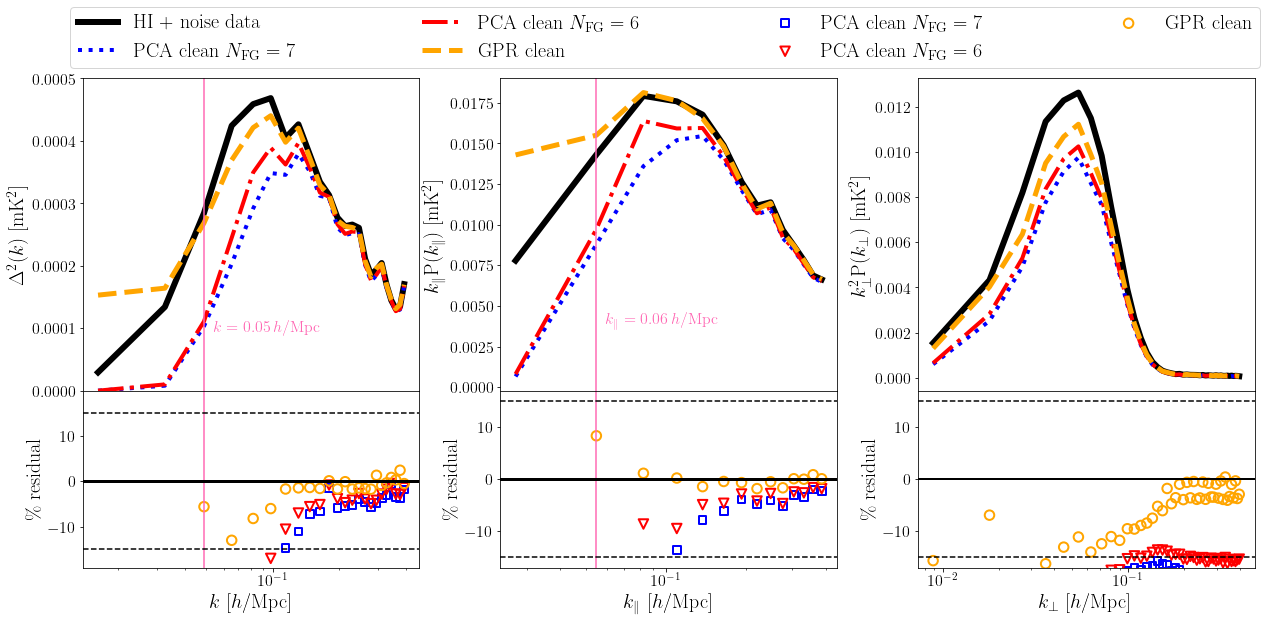

In [16]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=(21,9), gridspec_kw={'height_ratios': [3, 1.7]})
fig.subplots_adjust(hspace=0, wspace=0.24)

ax1.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + noise data')
ax1.plot(k, (k*k*k*PCA7_pk)/(2*np.pi*np.pi), ls='dotted',c='b', lw=4)
ax1.plot(k, (k*k*k*PCA6_pk)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=4)
ax1.plot(k, (k*k*k*GPR_pk)/(2*np.pi*np.pi), ls='dashed', c='orange', lw=5)
ax1.text(k[0]*3.3, 0.000095, r'$k = 0.05 \, h$/Mpc', c='hotpink')
ax1.axvline(k[2], c='hotpink')
ax1.set_xscale('log')
ax1.set_ylim(0,0.0005)
ax1.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax2.scatter(k, 100*(PCA7_pk - HI_pk)/HI_pk, marker='s', s=60, edgecolor='b', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 7$')
ax2.scatter(k, 100*(PCA6_pk - HI_pk)/HI_pk, marker='v', s=90, edgecolor='r', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 6$')
ax2.scatter(k, 100*(GPR_pk - HI_pk)/HI_pk, s=90, marker='o', edgecolor='orange', facecolor='none', lw=2, label = r'GPR clean')
ax2.set_ylim(-19.,19.9)
ax2.axvline(k[2], c='hotpink')
ax2.set_xscale('log')
ax2.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax2.set_ylabel('\% residual', fontsize=20)
ax2.axhline(0, c='k', lw=3)
ax2.axhline(15, c='k', ls='dashed', lw=1.5)
ax2.axhline(-15, c='k', ls='dashed', lw=1.5)

ax3.plot(kpar, kpar*HI_pk_para, ls='solid', c='k', lw=6)
ax3.plot(kpar, kpar*PCA7_pk_para, ls='dotted',c='b', lw=4, label = r'PCA clean $N_{\rm FG} = 7$')
ax3.plot(kpar, kpar*PCA6_pk_para, ls='dashdot',c='r', lw=4)
ax3.plot(kpar, kpar*GPR_pk_para, ls='dashed', c='orange', lw=5)
ax3.text(k[0]*3.64, 0.0039, r'$k_\parallel = 0.06 \, h$/Mpc', c='hotpink')
ax3.axvline(kpar[1], c='hotpink')
ax3.set_xscale('log')
ax3.set_ylabel('$k_\parallel$P($k_\parallel$) [mK$^2$]', fontsize=20)

ax4.scatter(kpar, 100*(PCA7_pk_para - HI_pk_para)/HI_pk_para, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(PCA6_pk_para - HI_pk_para)/HI_pk_para, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(GPR_pk_para - HI_pk_para)/HI_pk_para, s=90, marker='o', edgecolor='orange', facecolor='none', lw=2)
ax4.axvline(kpar[1], c='hotpink')
ax4.set_ylim(-17,17)
ax4.set_xscale('log')
ax4.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax4.set_ylabel('\% residual', fontsize=20)
ax4.axhline(0, c='k', lw=3)
ax4.axhline(15, c='k', ls='dashed', lw=1.5)
ax4.axhline(-15, c='k', ls='dashed', lw=1.5)

ax5.plot(kperp, kperp*kperp*HI_pk_perp, ls='solid', c='k', lw=6)
ax5.plot(kperp, kperp*kperp*PCA7_pk_perp, ls='dotted',c='b', lw=4)
ax5.plot(kperp, kperp*kperp*PCA6_pk_perp, ls='dashdot',c='r', lw=4, label = r'PCA clean $N_{\rm FG} = 6$')
ax5.plot(kperp, kperp*kperp*GPR_pk_perp, ls='dashed', c='orange', lw=5, label = r'GPR clean')
ax5.set_xscale('log')
ax5.set_ylabel('$k_\perp^2$P($k_\perp$) [mK$^2$]', fontsize=20)

ax6.scatter(kperp, 100*(PCA7_pk_perp - HI_pk_perp)/HI_pk_perp, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax6.scatter(kperp, 100*(PCA6_pk_perp - HI_pk_perp)/HI_pk_perp, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax6.scatter(kperp, 100*(GPR_pk_perp - HI_pk_perp)/HI_pk_perp, s=90, marker='o', edgecolor='orange', facecolor='none', lw=2)
ax6.set_ylim(-17,17)
ax6.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax6.set_ylabel('\% residual', fontsize=20)
ax6.axhline(0, c='k', lw=2)
ax6.axhline(15, c='k', ls='dashed', lw=1.5)
ax6.axhline(-15, c='k', ls='dashed', lw=1.5)

fig.legend(bbox_to_anchor=(0.11, 0.88, 0.8, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)

#plt.savefig('../figs/pk_all_wpol_hifreq', dpi=300, bbox_inches="tight")